# Quantitative Trading Strategies Using Python
## Technical Analysis, Statistical Testing,and Machine Learning
—
### Peng Liu

#######################################################################################################################

## CHAPTER 8
## Statistical Arbitrage with Hypothesis Testing

### Stationarity

##### Generating normal samples

In [ ]:
!pip install botorch
!pip install -U statsmodels
!pip install ta
!pip install yfinance
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.fit import fit_gpytorch_mll
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import ta
import torch
import torch.nn as nn
import yfinance as yf

In [ ]:
# generate random samples from normal distribution
def generate_normal_sample(params):
    """
    input: params, including mean in params[0] and standard deviation inparams[1]
    output: a random sample from the normal distribution parameterized by the input
    """
    mean = params[0]
    sd = params[1]
    return np.random.normal(mean, sd)
# Now we generate a sample by specifying a standard normal distribution:
# generate sample from standard norml
print(generate_normal_sample([0,1]))

-0.6772719159738075


##### Generating samples from stationary and non-stationary normal distributions

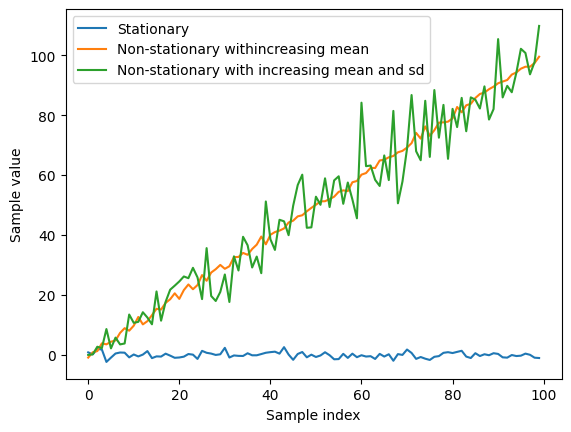

In [ ]:
# generate 100 random samples for both stationary and non-stationary distribution
T = 100
stationary_list, nonstationary_list1, nonstationary_list2 = [], [], []
for i in range(T):
    # generate a stationary sample and append to list
    stationary_list.append(generate_normal_sample([0,1]))
     # generate a non-stationary sample with an increasing mean and append to list
    nonstationary_list1.append(generate_normal_sample([i,1]))
    # generate a non-stationary sample with an increasing mean and sd and append to list
    nonstationary_list2.append(generate_normal_sample([i,np.sqrt(i)]))
x = range(T)
# plot the lists as line plots with labels for each line
plt.plot(x, stationary_list, label='Stationary')
plt.plot(x, nonstationary_list1, label='Non-stationary withincreasing mean')
plt.plot(x, nonstationary_list2, label='Non-stationary with increasing mean and sd')
# set the axis labels
plt.xlabel('Sample index')
plt.ylabel('Sample value')
# add a legend
plt.legend()
# show the plot
plt.show()

##### Testing stationarity of a time series

In [ ]:
# test for stationarity
def stationarity_test(x, threshold=0.05):
    """
    input:
    x: a list of scalar values
    threshold: significance level
    output: print out message on stationarity
    """
    pvalue = adfuller(x)[1]
    if pvalue < threshold:
        return 'p-value is ' + str(pvalue) + '. The series is likely stationary.'
    else:
        return 'p-value is ' + str(pvalue) + '. The series is likely non-stationary.'

In [ ]:
print(stationarity_test(stationary_list))
print(stationarity_test(nonstationary_list1))
print(stationarity_test(nonstationary_list2))

p-value is 7.961545999577389e-14. The series is likely stationary.
p-value is 0.9541039832024609. The series is likely non-stationary.
p-value is 0.9732802990316017. The series is likely non-stationary.


### Test for Cointegration

##### Importing packages and downloading stock data

In [ ]:
SEED = 8
random.seed(SEED)
np.random.seed(SEED)
# download data from yfinance
start_date = "2022-01-01"
end_date = "2022-12-31"
stocks = ['GOOG','MSFT']
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%%**********************]  2 of 2 completed


Ticker,GOOG,MSFT
Date,,
2022-01-03,144.909592,327.530121
2022-01-04,144.252350,321.913910
2022-01-05,137.497040,309.556366
2022-01-06,137.394653,307.110291
2022-01-07,136.848770,307.266785


##### Extracting residuals from OLS

In [ ]:
# build linear regression model
# Extract prices for two stocks of interest
# target var: Y; predictor: X
Y = df[stocks[0]]
X = df[stocks[1]]
# estimate linear regression coefficients of stock1 on stock2
X_with_constant = sm.add_constant(X)

In [ ]:
X_with_constant

,const,MSFT
Date,,
2022-01-03,1.0,327.530121
2022-01-04,1.0,321.913910
2022-01-05,1.0,309.556366
2022-01-06,1.0,307.110291
2022-01-07,1.0,307.266785
...,...,...
2022-12-23,1.0,235.769745
2022-12-27,1.0,234.021713
2022-12-28,1.0,231.621841


In [ ]:
model = OLS(Y, X_with_constant).fit()
residuals = Y - model.predict()

In [ ]:
residuals

Date
2022-01-03    -9.131536
2022-01-04    -6.330760
2022-01-05    -5.477272
2022-01-06    -4.073558
2022-01-07    -4.715798
                ...    
2022-12-23    -7.834430
2022-12-27    -8.635991
2022-12-28    -8.626671
2022-12-29   -10.079897
2022-12-30    -9.576024
Name: GOOG, Length: 251, dtype: float64

In [ ]:
# access model weights
print(model.params)

const   -47.626014
MSFT      0.615721
dtype: float64


In [ ]:
# alternative approach
residuals2 = Y - (model.params['const'] + model.params[stocks[1]] * X)
# check if both residuals are the same
print(residuals.equals(residuals2))

False


##### Testing stationarity of the residuals

In [ ]:
# test stationarity of the residuals
adf_test = adfuller(residuals)
print(f"ADF test statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The two stocks are cointegrated.")
else:
    print("The two stocks are not cointegrated.")

ADF test statistic: -3.179797822299416
p-value: 0.021184247626497534
The two stocks are cointegrated.


###  Correlation and Cointegration

<Axes: >

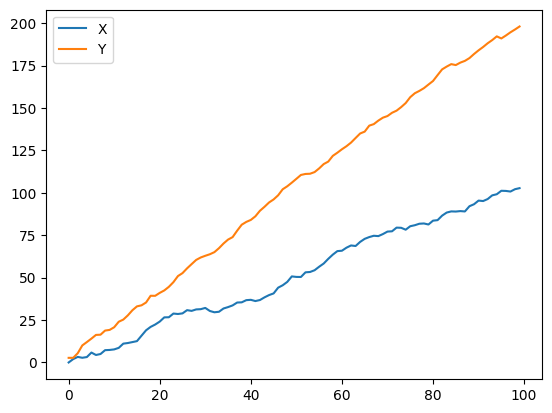

In [ ]:
np.random.seed(123)
X = np.random.normal(1, 1, 100)
Y = np.random.normal(2, 1, 100)
X = pd.Series(np.cumsum(X), name='X')
Y = pd.Series(np.cumsum(Y), name='Y')
pd.concat([X, Y], axis=1).plot()

In [ ]:
from statsmodels.tsa.stattools import coint
# calculate the correlation coefficeint
print('Correlation: ' + str(X.corr(Y)))
# perform in cointegration test
score, pvalue, _ = coint(X,Y)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.994833254077976
Cointegration test p-value: 0.17830098966789215


### Implementing the Pairs Trading Strategy

In [ ]:
# download data from yfinance
stocks = ['GOOG','MSFT','AAPL','TSLA','META','NFLX']
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  6 of 6 completed


In [ ]:
df

Ticker,AAPL,GOOG,META,MSFT,NFLX,TSLA
Date,,,,,,
2022-01-03,179.481094,144.909592,337.845764,327.530121,597.369995,399.926666
2022-01-04,177.203217,144.252350,335.839874,321.913910,591.150024,383.196655
2022-01-05,172.489609,137.497040,323.505249,309.556366,567.520020,362.706665
2022-01-06,169.610214,137.394653,331.778198,307.110291,553.289978,354.899994
2022-01-07,169.777847,136.848770,331.109589,307.266785,541.059998,342.320007
...,...,...,...,...,...,...
2022-12-23,130.782578,89.707916,117.797935,235.769745,294.959991,123.150002
2022-12-27,128.967529,87.830055,116.640312,234.021713,284.170013,109.099998
2022-12-28,125.010132,86.361725,115.382896,231.621841,276.880005,112.709999


### Identifying Cointegrated Pairs of Stocks

##### Generating all unique pairs of stocks

In [ ]:
# get all pairs of stocks
stock_pairs = list(combinations(df.columns, 2))

In [ ]:
stock_pairs

[('AAPL', 'GOOG'),
 ('AAPL', 'META'),
 ('AAPL', 'MSFT'),
 ('AAPL', 'NFLX'),
 ('AAPL', 'TSLA'),
 ('GOOG', 'META'),
 ('GOOG', 'MSFT'),
 ('GOOG', 'NFLX'),
 ('GOOG', 'TSLA'),
 ('META', 'MSFT'),
 ('META', 'NFLX'),
 ('META', 'TSLA'),
 ('MSFT', 'NFLX'),
 ('MSFT', 'TSLA'),
 ('NFLX', 'TSLA')]

### Testing Pairwise Cointegration

##### Performing a cointegration test for each unique pair of stocks

In [ ]:
threshold = 0.1 # Significance level
# run Engle-Granger test for cointegration on each pair of stocks
for pair in stock_pairs:
    # subset df based on current pair of stocks
    df2 = df[list(pair)]
    # perform test for the current pair of stocks
    score, pvalue, _ = coint(df2.values[:,0], df2.values[:,1])
    # check if the current pair of stocks is cointegrated
    if pvalue < threshold:
        print(pair, 'are cointegrated')
    else:
        print(pair, 'are not cointegrated')

('AAPL', 'GOOG') are not cointegrated
('AAPL', 'META') are not cointegrated
('AAPL', 'MSFT') are not cointegrated
('AAPL', 'NFLX') are not cointegrated
('AAPL', 'TSLA') are not cointegrated
('GOOG', 'META') are not cointegrated
('GOOG', 'MSFT') are cointegrated
('GOOG', 'NFLX') are not cointegrated
('GOOG', 'TSLA') are not cointegrated
('META', 'MSFT') are not cointegrated
('META', 'NFLX') are not cointegrated
('META', 'TSLA') are not cointegrated
('MSFT', 'NFLX') are not cointegrated
('MSFT', 'TSLA') are not cointegrated
('NFLX', 'TSLA') are not cointegrated


In [ ]:
df2

Ticker,NFLX,TSLA
Date,,
2022-01-03,597.369995,399.926666
2022-01-04,591.150024,383.196655
2022-01-05,567.520020,362.706665
2022-01-06,553.289978,354.899994
2022-01-07,541.059998,342.320007
...,...,...
2022-12-23,294.959991,123.150002
2022-12-27,284.170013,109.099998
2022-12-28,276.880005,112.709999


### Obtaining the Spread

##### Calculating the spread

<Axes: xlabel='Date'>

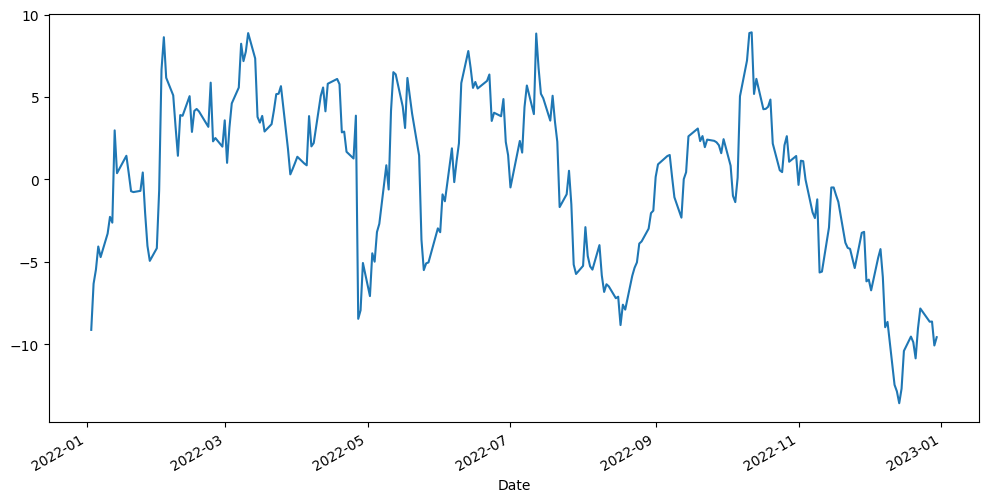

In [ ]:
# calculate the spread for GOOG and MSFT
Y = df["GOOG"]
X = df["MSFT"]
# estimate linear regression coefficients
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
# obtain the spread as the residuals
spread = Y - model.predict()
spread.plot(figsize=(12,6))

### Converting to Z-Scores

##### Calculating the z-score

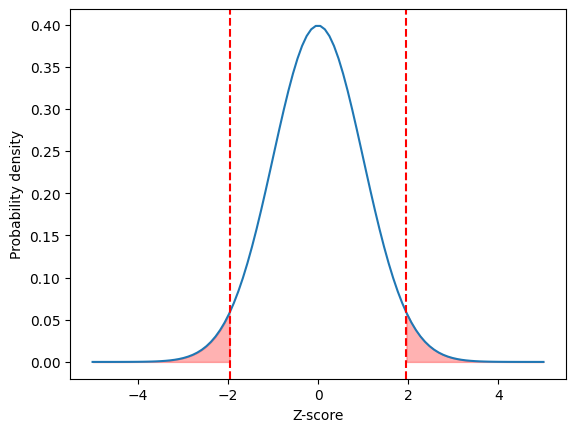

In [ ]:
# illustrate z score by generating a standard normal distribution with mu 0 and sd 1
from scipy.stats import norm
# input: unbounded scalar, assumed to be in the range of [-5,-5] in this case
x = np.linspace(-5, 5, 100)
# output: probability between 0 and 1
y = norm.pdf(x, loc=0, scale=1)
# set up the plot
fig, ax = plt.subplots()
# plot the pdf of normal distribution
ax.plot(x, y)
# shade the area corresponding to a z-score of >=1.96 and <=-1.96
z_critical = 1.96
x_shade = np.linspace(z_critical, 5, 100)
y_shade = norm.pdf(x_shade, loc=0, scale=1)
ax.fill_between(x_shade, y_shade, color='red', alpha=0.3)
z_critical2 = -1.96
x_shade2 = np.linspace(-5, z_critical2, 100)
y_shade2 = norm.pdf(x_shade2, loc=0, scale=1)
ax.fill_between(x_shade2, y_shade2, color='red', alpha=0.3)
# add labels and a title
ax.set_xlabel('Z-score')
ax.set_ylabel('Probability density')
# add a vertical line to indicate the z-score of 1.96 and -1.96
ax.axvline(x=z_critical, linestyle='--', color='red')
ax.axvline(x=z_critical2, linestyle='--', color='red')
# display the plot
plt.show()

##### Converting to z-scores based on moving averages

<Axes: xlabel='Date'>

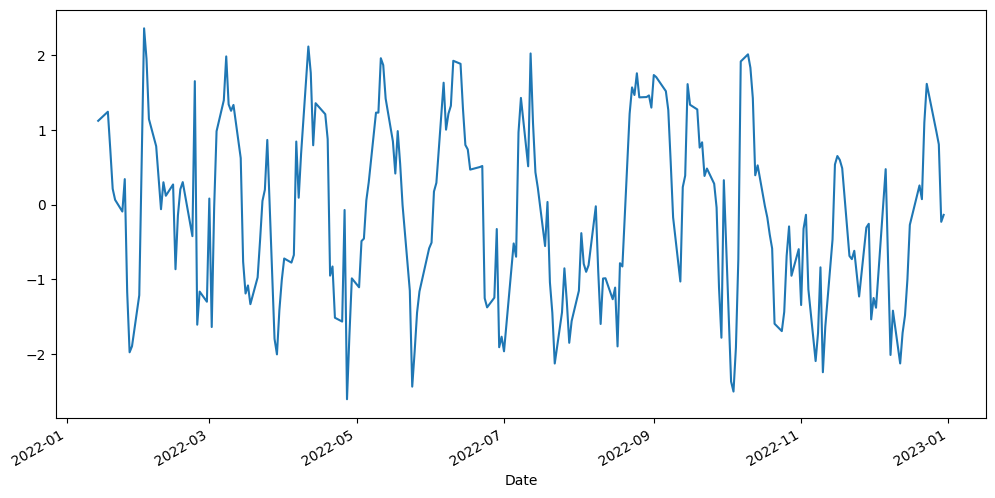

In [ ]:
# convert to z score
# z-score is a measure of how many standard deviations the spread is from its mean
# derive mean and sd using a moving window
window_size = 10
spread_mean = spread.rolling(window=window_size).mean()
spread_std = spread.rolling(window=window_size).std()
zscore = (spread - spread_mean) / spread_std
zscore.plot(figsize=(12,6))

In [ ]:
# remove initial days with NA
first_valid_idx = zscore.first_valid_index()
zscore = zscore[first_valid_idx:]
zscore

Date
2022-01-14    1.123747
2022-01-18    1.245483
2022-01-19    0.742043
2022-01-20    0.211877
2022-01-21    0.064888
                ...   
2022-12-23    1.618941
2022-12-27    0.977237
2022-12-28    0.807604
2022-12-29   -0.230087
2022-12-30   -0.137034
Name: GOOG, Length: 242, dtype: float64

### Formulating the Trading Strategy

##### Implementing pairs trading

In [ ]:
# set the threshold values for entry and exit signals
entry_threshold = 2.0
exit_threshold = 1.0
# initialize the daily positions to be zeros
stock1_position = pd.Series(data=0, index=zscore.index)

In [ ]:
stock2_position = pd.Series(data=0, index=zscore.index)
# generate daily entry and exit signals for each stock
for i in range(1, len(zscore)):
    # zscore<-2 and no existing long position for stock 1
    if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
        stock1_position[i] = 1 # long stock 1
        stock2_position[i] = -1 # short stock 2
    # zscore>2 and no existing short position for stock 2
    elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
        stock1_position[i] = -1 # short stock 1
        stock2_position[i] = 1 # long stock 2
    # -1<zscore<1
    elif abs(zscore[i]) < exit_threshold:
        stock1_position[i] = 0 # exit existing position
        stock2_position[i] = 0
        # -2<zscore<-1 or 1<zscore<2
    else:
        stock1_position[i] = stock1_position[i-1] # maintain existingposition
        stock2_position[i] = stock2_position[i-1]

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_4965/2075529295.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_4965/2075529295.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_4965/2075529295.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

##### Calculating the cumulative return

In [ ]:
# Calculate the returns of each stock
stock1_returns = (df["GOOG"][first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0)
stock2_returns = (df["MSFT"][first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)

<Axes: xlabel='Date'>

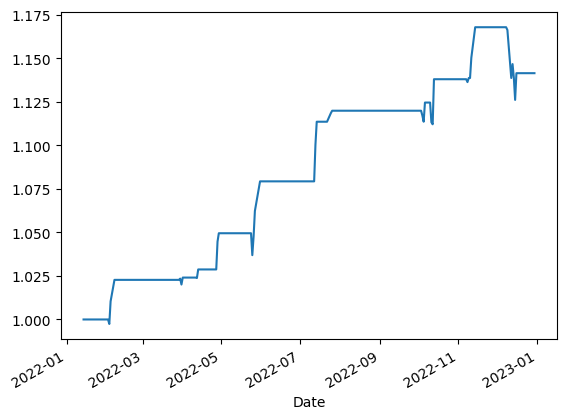

In [ ]:
# calculate the total returns of the strategy
total_returns = stock1_returns + stock2_returns
cumulative_returns = (1 + total_returns).cumprod()
# plot the cumulative returns
cumulative_returns.plot()

##############################################################################################################################